# Info 98 Final Project
### By Calvin Chen, Jusheen Kim, Jamila Hussein

In [1]:
import numpy as np
import pandas as pd
from datascience import *
import sys
import scipy
import sklearn

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)
from matplotlib import patches
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
sqrt = np.sqrt

from pandas.plotting import scatter_matrix
from sklearn import model_selection, datasets, linear_model
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Dataset 1

In [2]:
# Data extraction and cleaning
cleaning, cleaned = open('haberman.data.txt').read().split("\n"), Table(['Age', 'Year Op', 'Num of Pos Aux Nodes', 'Survival Status'])
cleaning = cleaning[0:len(cleaning)-1]
for i in range(len(cleaning)):
    cleaned = cleaned.with_row([int(j) for j in cleaning[i].split(',')])
random_cleaned = cleaned.sample(with_replacement=False)

train_set = random_cleaned.take(np.arange(0, int(random_cleaned.num_rows * 0.8)))
train_status, train_set = train_set.column('Survival Status'), train_set.drop('Survival Status')

test_set = random_cleaned.take(np.arange(int(random_cleaned.num_rows * 0.8), random_cleaned.num_rows))
test_status, test_set = test_set.column('Survival Status'), test_set.drop('Survival Status')

In [3]:
# RMSE (Used for kNN to determine nearest neighbors and used for LinReg to determine accuracy of the regression)
def RMSE(array1, array2):
    return sqrt(sum((array1 - array2) ** 2))

In [4]:
# Creating the kNN Model
def distances(test_row, train_set):
    distances = make_array()
    for row in train_set.rows:
        distances = np.append(distances, RMSE(make_array(row)[0], test_row))
    return distances

def classify(test_row, train_set, k):
    classes_and_distances = Table().with_columns('Test Status', train_status, 'Distances', distances(test_row, train_set)).sort('Distances')
    return classes_and_distances.take(np.arange(k)).group('Test Status').sort('count', descending=True).column(0).item(0)

def accuracy(test_set, train_set, k):
    classes = make_array()
    for row in test_set.rows:
        classes = np.append(classes, classify(make_array(row)[0], train_set, k))
    comparison = Table().with_columns('Predicted Status', classes, 'Actual Status', test_status)
    return np.count_nonzero(comparison.column(0) == comparison.column(1)) / len(comparison.column(0)) * 100

In [5]:
# Testing
best_k = Table(['k', 'Accuracy'])
for i in range(1, 20): # Only using k-values from 1 to 20
    best_k = best_k.with_row([i, accuracy(test_set, train_set, i)])
best_k.where('Accuracy', are.equal_to(max(best_k.column(1))))

k,Accuracy
15,87.0968
16,87.0968
17,87.0968


In [6]:
# Creating the linear regression
def standard_units(xyz):
    return (xyz - np.mean(xyz))/np.std(xyz)

def correlation(t, label_x, label_y):
    return np.mean(standard_units(t.column(label_x))*standard_units(t.column(label_y)))

def slope(t, label_x, label_y):
    r = correlation(t, label_x, label_y)
    return r*np.std(t.column(label_y))/np.std(t.column(label_x))

def intercept(t, label_x, label_y):
    return np.mean(t.column(label_y)) - slope(t, label_x, label_y)*np.mean(t.column(label_x))

In [7]:
# Linear regression on Training Set w/ Residuals
intercept, slope = intercept(train_set, 'Num of Pos Aux Nodes', 'Age'), slope(train_set, 'Num of Pos Aux Nodes', 'Age')

lin_train = train_set
guesses = lin_train.with_column('Guesses', slope * train_set.column('Num of Pos Aux Nodes') + intercept)
residuals = guesses.with_column('Residuals', guesses.column('Guesses') - guesses.column('Age'))

accuracy = np.count_nonzero(np.round(residuals.column('Residuals')) == 0) / len(residuals.column('Residuals')) * 100
print("Training set accuracy: %s" % accuracy)

Training set accuracy: 4.098360655737705


In [8]:
# Testing
test_ages, test_nodes = test_set.column('Age'), test_set.column('Num of Pos Aux Nodes')
accuracy = np.count_nonzero(np.round(test_ages - (slope * test_nodes + intercept)) == 0) / len(test_nodes) * 100
print("Training set accuracy: %s" % accuracy)

Training set accuracy: 1.6129032258064515


### Explanation

The dataset I chose was the Haberman dataset, where the data consisted of three variables, age, year of operation, and the number of positive auxiliary nodes, and an outcome which was whether or not that patient survived after breast cancer surgery. So, for this dataset, I decided to use K-Nearest Neighbors and Linear Regression. I processed my data in the beginning by opening the text file, and then parsing through the data by splitting lines with .split("\n") and then parsed through every line and appended them to a table with .split(" "). Once I was done with that, I converted each cell to an integer rather than a string, and then I was finally done with cleaning my data and could begin testing models off of it.

The first thing I did after that was split my data into a test_set and a train_set (20% of the data and 80% of the data respectively). From there, I built my kNN model by comparing each row in the test_set with the closest k neighbors in the train_set, and then determined the classification of each row in the test_set by the most common class of the k nearest neighbors selected. I didn't end up selecting certain features, as there were only 3 to begin with, so I just built the model around the features provided. I also went further to determine the accuracy of the model, and determine the k-values that corresponded to the highest accuracy k-value(s).

Results: pretty accurate (around 80% accuracy for every model).

The next thing I did was built the linear regression model. I didn't end up using linear regression to determine whether or not someone had survived a surgery for breast cancer, but rather determine the relationship between the Age and the Number of Positive Auxiliary Nodes each person had. I figured that if there was a correlation between those two variables, and a correlation between the Number of Positive Auxiliary Nodes each person had and whether or not someone survived the surgery (it seemed the most logical), then I could deduce that there is a correlation between Age and Survival Status. So, I build my linear regression pertaining to Age and Number of Positive Auxiliary Nodes, and found the best fit line for the two variables. After that, I trained my train_set on that data, and determined how accurate my model was with the training data. Once I determined that accuracy, I went on to determine how accurate my model was on the test data, which was the premise of making the linear regression model.

Results: pretty terribly inaccurate (on average less than 3% accuracy for each linear regression model).

# Dataset 2

In [9]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = pd.read_csv(url, names=names)

In [10]:
print(dataset.shape)

(150, 5)


In [11]:
print(dataset.describe())

       sepal-length  sepal-width  petal-length  petal-width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [12]:
print(dataset.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


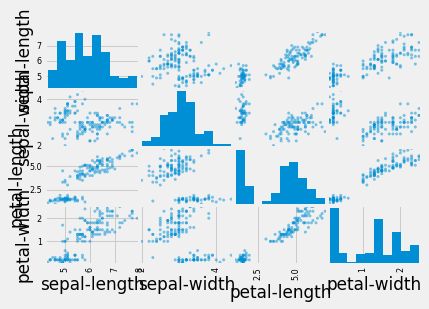

In [13]:
scatter_matrix(dataset)
plt.show()

In [14]:
array = dataset.values
X = array[:,0:4]
Y = array[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [15]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

In [16]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = model_selection.KFold(n_splits=10, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

LR: 0.966667 (0.040825)
KNN: 0.983333 (0.033333)


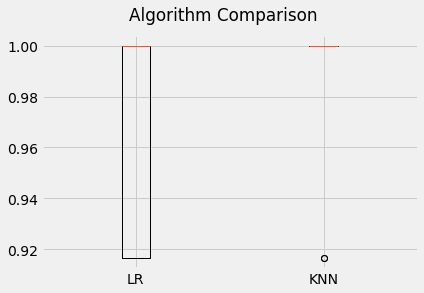

In [17]:
# Comparing the Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [18]:
# Using KNN Algorithm to make Predications on the Validation Data Set
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.9
[[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.85      0.92      0.88        12
 Iris-virginica       0.90      0.82      0.86        11

    avg / total       0.90      0.90      0.90        30



In [19]:
# Using Logistic Regression Algorithm for Prediction test on Validation Set data
logr = LogisticRegression()
logr.fit(X_train, Y_train)
predictions = logr.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.8
[[ 7  0  0]
 [ 0  7  5]
 [ 0  1 10]]
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         7
Iris-versicolor       0.88      0.58      0.70        12
 Iris-virginica       0.67      0.91      0.77        11

    avg / total       0.83      0.80      0.80        30



#### Explanation

First I thought about what the models are supposed to tell me
If given a future data set, these models will be able predict what kind of flower each plant is up to a certain % accuracy.

Second I loaded some Python libraries for certain useful functions
I also imported libraries, and some of their functions 

After, I loaded the data set I chose: Iris

I then visualized the data so I could get a feel for what I was working with
I also got some general statistical info about the data set in addtion to the scatterplot matrix

I split the data into two groups: a set to train the models and a set to test my model on after 
This allowed me to check if my model was decently accurate, since it is important to test the models on data it has never
seen before.

Now I trained the models using the first data set

Just to see which one was more reliable/accurate, I created a box and whisker plot. 
We can see that while logistic regression is decently accurate, the KNN model was very accurate

Then I tested the models on the second set of data that I saved earlier
Results: Logistic regression model was around 80% accurate and the KNN model was around 90% accurate.

# Dataset 3

In [20]:
#Import dataset forestfires.csv. 
df = pd.read_csv('forestfires.csv')

#Shows the first 5 data points in the dataset
df.head()

## As we can see, we have a problem with "month" and "day" being categorical variables however, we need to clean this up and transform them into numerical variables. 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [21]:
#Create a set of dummy variables from the month and day variable
df = pd.get_dummies(df)

In [22]:
#Check columns of the data
df.columns

Index(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'area', 'month_apr', 'month_aug', 'month_dec', 'month_feb', 'month_jan',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'month_sep', 'day_fri', 'day_mon', 'day_sat', 'day_sun',
       'day_thu', 'day_tue', 'day_wed'],
      dtype='object')

In [23]:
#Drop one column of month and day, in order to avoid multicollinearity
df.drop(labels=['month_nov', 'day_sat'], axis=1, inplace=True)

In [24]:
#Check the range of values of each column
df.max()-df.min()

X               8.00
Y               7.00
FFMC           77.50
DMC           290.20
DC            852.70
ISI            56.10
temp           31.10
RH             85.00
wind            9.00
rain            6.40
area         1090.84
month_apr       1.00
month_aug       1.00
month_dec       1.00
month_feb       1.00
month_jan       1.00
month_jul       1.00
month_jun       1.00
month_mar       1.00
month_may       1.00
month_oct       1.00
month_sep       1.00
day_fri         1.00
day_mon         1.00
day_sun         1.00
day_thu         1.00
day_tue         1.00
day_wed         1.00
dtype: float64

In [25]:
#:: Linear Regression ::
#Import LinearRegression package
from sklearn.linear_model import LinearRegression

#Copy df into data and establish the target as 'area'
data = df.copy()
target = data.pop('area')

#LR = data and target
lr = LinearRegression(fit_intercept=True)
lr.fit(data, target)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [26]:
#Import MSE package 
#Look at R^2 and Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_squared_error
print(lr.score(data, target))
predictions = lr.predict(data)
mse = mean_squared_error(target, predictions)
rmse = np.sqrt(mse)
print(rmse)


## R^2 = 0.04578 is very small; RMSE = 62.12 is large

0.04578209650808518
62.12143311792724


In [27]:
#Import package
import statsmodels.formula.api as smf
#Set up statistics; define the data attributes
df_attributes = df.columns.values.tolist()
number_of_columns = len(df_attributes)

#Create models to test each column
statistics = list()
for idx in range(0, number_of_columns - 1):
    model = smf.ols(formula = "area ~ " + 
                    df_attributes[idx], data = df).fit()
    
    title = 'Model: area ~ ' + df_attributes[idx]
#Print the model which allows us to see the relationship between X=all columns except for area and y=area. The relationship in terms of r-squared, p-value, log-likelihood.
    print()
    print(model.summary())
    print()
    statistics.append([model.f_pvalue, model.rsquared])


                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     2.077
Date:                Sat, 28 Apr 2018   Prob (F-statistic):              0.150
Time:                        23:29:24   Log-Likelihood:                -2879.4
No. Observations:                 517   AIC:                             5763.
Df Residuals:                     515   BIC:                             5771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.7049      6.304      0.746      0.


                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                 0.0005257
Date:                Sat, 28 Apr 2018   Prob (F-statistic):              0.982
Time:                        23:29:25   Log-Likelihood:                -2880.4
No. Observations:                 517   AIC:                             5765.
Df Residuals:                     515   BIC:                             5773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.8387      2.827      4.541      0.


                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.1467
Date:                Sat, 28 Apr 2018   Prob (F-statistic):              0.702
Time:                        23:29:25   Log-Likelihood:                -2880.4
No. Observations:                 517   AIC:                             5765.
Df Residuals:                     515   BIC:                             5773.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.0328      2.843      4.583      0.

In [28]:
#Summarize the model - the p-value and R-squared
statistics = pd.DataFrame(statistics, 
                              index=df_attributes[: number_of_columns - 1], 
                              columns=['p-value', 'R-squared'])
statistics.T

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_jun,month_mar,month_may,month_oct,month_sep,day_fri,day_mon,day_sun,day_thu,day_tue
p-value,0.150096,0.308510,0.362592,0.097335,0.262363,0.851418,0.026101,0.086271,0.779939,0.867310,...,0.644924,0.300773,0.887006,0.701822,0.199054,0.229755,0.630475,0.642497,0.648064,0.975874
R-squared,0.004018,0.002014,0.001610,0.005328,0.002439,0.000068,0.009573,0.005703,0.000152,0.000054,...,0.000413,0.002079,0.000039,0.000285,0.003200,0.002800,0.000450,0.000419,0.000405,0.000002


In [29]:
#Find statistically significant column
statistics[statistics['p-value'] < 0.05]

##temp is the only statistically significant column (p-value = 0.026) accounting for (1% of forest fires)

,p-value,R-squared
temp,0.026101,0.009573
area,0.000000,1.000000


In [30]:
#Linear regression relationship between area and temp
print((smf.ols(formula = "area ~ temp", data = df).fit()).summary())

                            OLS Regression Results                            
Dep. Variable:                   area   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     4.978
Date:                Sat, 28 Apr 2018   Prob (F-statistic):             0.0261
Time:                        23:29:25   Log-Likelihood:                -2878.0
No. Observations:                 517   AIC:                             5760.
Df Residuals:                     515   BIC:                             5768.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.4138      9.500     -0.780      0.4

In [31]:
## :: Train/Test Split ::
#Import LogisiticRegression and Train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

#Create training and testing variabels
X_train, X_test, y_train, y_test = train_test_split(data, target, shuffle=True, test_size=0.5, random_state=0)

In [32]:
#Print variables
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(258, 27)
(259, 27)
(258,)
(259,)


In [33]:
#Model with the training data to predict test data 
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
predictions[0:5]

array([10.93205541,  9.95865732, 15.37412386, 30.87723729,  5.66272802])

In [34]:
## :: Cross Validation ::
#Import KFold
from sklearn.model_selection import KFold 
#Create array(2)
X = np.array([[1,2], [3,4], [1,2], [3,4]])
y = np.array([1,2,3,4])
#Define split
kf = KFold(n_splits=2)
kf.get_n_splits(X)
print(kf)
KFold(n_splits=2, random_state=None, shuffle=False)

KFold(n_splits=2, random_state=None, shuffle=False)


KFold(n_splits=2, random_state=None, shuffle=False)

In [35]:
#This function will split the data(df)
for train_index, test_index in kf.split(X):
    print("Train:", train_index, "Test:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

Train: [2 3] Test: [0 1]
Train: [0 1] Test: [2 3]


In [36]:
df['area'].unique()[0:5]

array([0.  , 0.36, 0.43, 0.47, 0.55])

In [37]:
#Import DecisionTreeRegressor and StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [38]:
#Criterior for the decision tree regressor is Mean Absolute Error(MAE)
dt = DecisionTreeRegressor(criterion='mae')
#Build a decision tree regressor from the training and testing set
dt.fit(scaler.fit_transform(X_train, y_test),
               scaler.fit_transform(X_test, y_train))
x=dt.predict(X_test)
print(np.sqrt(np.mean((y_test-x))))

1.5811388300841898


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
## :: Logisitic Regression ::
#Check if dataset size is sufficient (50 records per feature=good)
forestfires_dmy = pd.concat([df], axis=1)
forestfires_dmy.head()
forestfires_dmy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 28 columns):
X            517 non-null int64
Y            517 non-null int64
FFMC         517 non-null float64
DMC          517 non-null float64
DC           517 non-null float64
ISI          517 non-null float64
temp         517 non-null float64
RH           517 non-null int64
wind         517 non-null float64
rain         517 non-null float64
area         517 non-null float64
month_apr    517 non-null uint8
month_aug    517 non-null uint8
month_dec    517 non-null uint8
month_feb    517 non-null uint8
month_jan    517 non-null uint8
month_jul    517 non-null uint8
month_jun    517 non-null uint8
month_mar    517 non-null uint8
month_may    517 non-null uint8
month_oct    517 non-null uint8
month_sep    517 non-null uint8
day_fri      517 non-null uint8
day_mon      517 non-null uint8
day_sun      517 non-null uint8
day_thu      517 non-null uint8
day_tue      517 non-null uint8
day_wed      51

In [40]:
X = df.ix[:,(1,2,3,4,5,6,)].values
y = df.ix[:,0].values

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

In [42]:
#Create the model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
y_pred = logreg.predict(X_test)

In [44]:
from sklearn.metrics import confusion_matrix 
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix [0:5]

array([[ 6,  4,  0,  4,  0,  0,  4,  2,  0],
       [ 9,  6,  0, 16,  0,  0,  3,  3,  1],
       [ 1,  3,  0, 23,  0,  0,  4,  4,  1],
       [ 8,  4,  0, 19,  0,  0,  2,  2,  0],
       [ 0,  3,  0, 11,  0,  0,  1,  2,  0]])

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.19      0.30      0.24        20
          2       0.29      0.16      0.20        38
          3       0.00      0.00      0.00        36
          4       0.14      0.54      0.22        35
          5       0.00      0.00      0.00        17
          6       1.00      0.02      0.04        46
          7       0.17      0.10      0.12        30
          8       0.48      0.80      0.60        30
          9       0.00      0.00      0.00         7

avg / total       0.33      0.23      0.17       259



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
